<a href="https://colab.research.google.com/github/xxxxyd/5329A1/blob/main/5329A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [1]:
import os
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from PIL import Image
from collections import Counter

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from transformers import BertTokenizer, BertModel

import seaborn as sns
from torch.cuda.amp import GradScaler, autocast


# Loading Data

In [2]:
def read_data(path):
    with open(path, "r", encoding="utf-8") as file:
        lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
        df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
    return df

# Data preprocess

In [3]:
class TrainImageDataset(Dataset):
    def __init__(self, data, img_dir, tokenizer, transform=None):
        self.data_frame = data
        self.img_dir = img_dir
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data_frame)

    def preprocess_text(self, text):
        text = re.sub(r'[^\\w\\s]', '', text)
        return text.lower()

    def __getitem__(self, idx):
        img_name = self.data_frame.iloc[idx]['ImageID']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        label_str = self.data_frame.iloc[idx]['Labels']
        label_ids = [int(x) for x in label_str.split()]
        label_tensor = torch.zeros(19, dtype=torch.float32)
        for l in label_ids:
            if 1 <= l <= 19:
                label_tensor[l - 1] = 1

        if self.transform:
            image = self.transform(image)

        caption = self.data_frame.iloc[idx]['Caption']
        caption = self.preprocess_text(caption)
        text_inputs = self.tokenizer(caption, return_tensors='pt', padding='max_length', max_length=128, truncation=True)

        input_ids = text_inputs['input_ids'].squeeze(0)
        attention_mask = text_inputs['attention_mask'].squeeze(0)

        return image, label_tensor, input_ids, attention_mask


In [4]:
class ImageTestDataset(Dataset):
    def __init__(self, data, img_dir, tokenizer, transform=None):
        self.data_frame = data
        self.img_dir = img_dir
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data_frame)

    def preprocess_text(self, text):
        text = re.sub(r'[^\\w\\s]', '', text)
        return text.lower()

    def __getitem__(self, idx):
        img_name = self.data_frame.iloc[idx]['ImageID']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        caption = self.data_frame.iloc[idx]['Caption']
        caption = self.preprocess_text(caption)
        text_inputs = self.tokenizer(caption, return_tensors='pt', padding='max_length', max_length=128, truncation=True)

        input_ids = text_inputs['input_ids'].squeeze(0)
        attention_mask = text_inputs['attention_mask'].squeeze(0)

        return image, img_name, input_ids, attention_mask


In [6]:
from sklearn.model_selection import train_test_split

# Load full train and test data
train_data = read_data("/content/train.csv")
test_data = read_data("/content/test.csv")

train_data = train_data.reset_index(drop=True)

# Split into train/validation
train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Define image transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # 只在训练集增强，且p=0.5更合理
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-mini')

# Create datasets
image_folder = "COMP5329S1A2Dataset/data"

train_dataset = TrainImageDataset(train_data, image_folder, tokenizer, train_transform)
valid_dataset = TrainImageDataset(valid_data, image_folder, tokenizer, valid_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=0)

print("Train size:", len(train_loader.dataset))
print("Valid size:", len(valid_loader.dataset))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Train size: 23996
Valid size: 6000


# Data exploration

FileNotFoundError: [Errno 2] No such file or directory: 'COMP5329S1A2Dataset/data/29478.jpg'

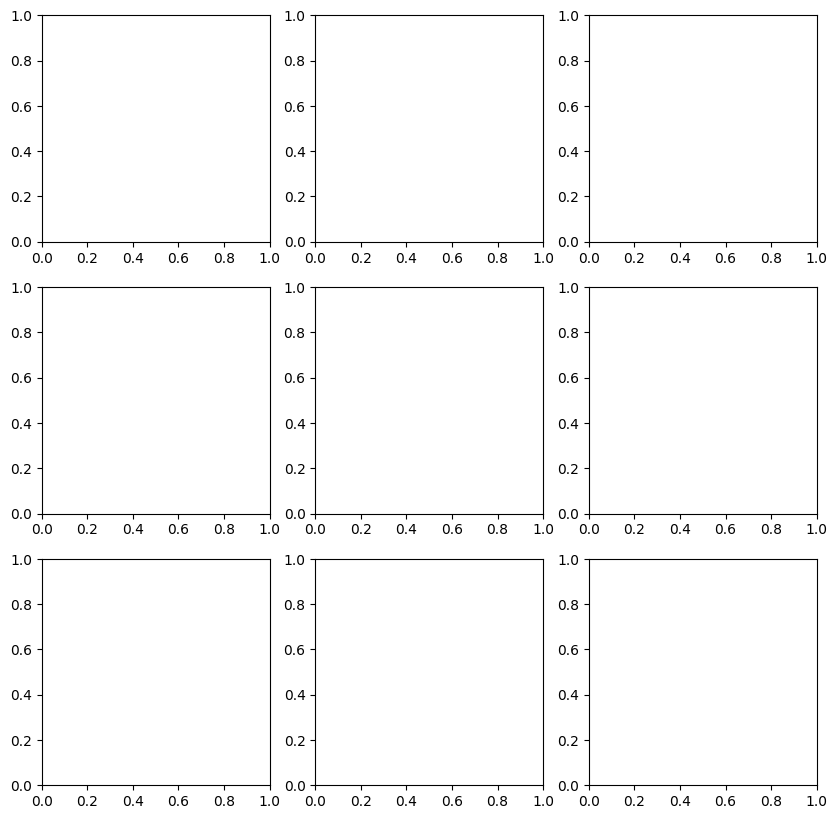

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

batch_data = next(iter(train_loader))
images, label_tensors, input_ids, attention_masks = next(iter(train_loader))


for i in range(9):
    image = images[i]
    label_tensor = label_tensors[i]
    label_indices = torch.nonzero(label_tensor).squeeze().tolist()
    label_str = " ".join([str(idx + 1) for idx in label_indices]) if isinstance(label_indices, list) else str(label_indices + 1)

    image = image.permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())

    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.set_title('Labels: {}'.format(label_str))
    ax.axis('off')

plt.tight_layout()
plt.savefig('train_img_label_preview.png')
plt.show()

Missing values per column:
ImageID    0
Labels     0
Caption    0
dtype: int64


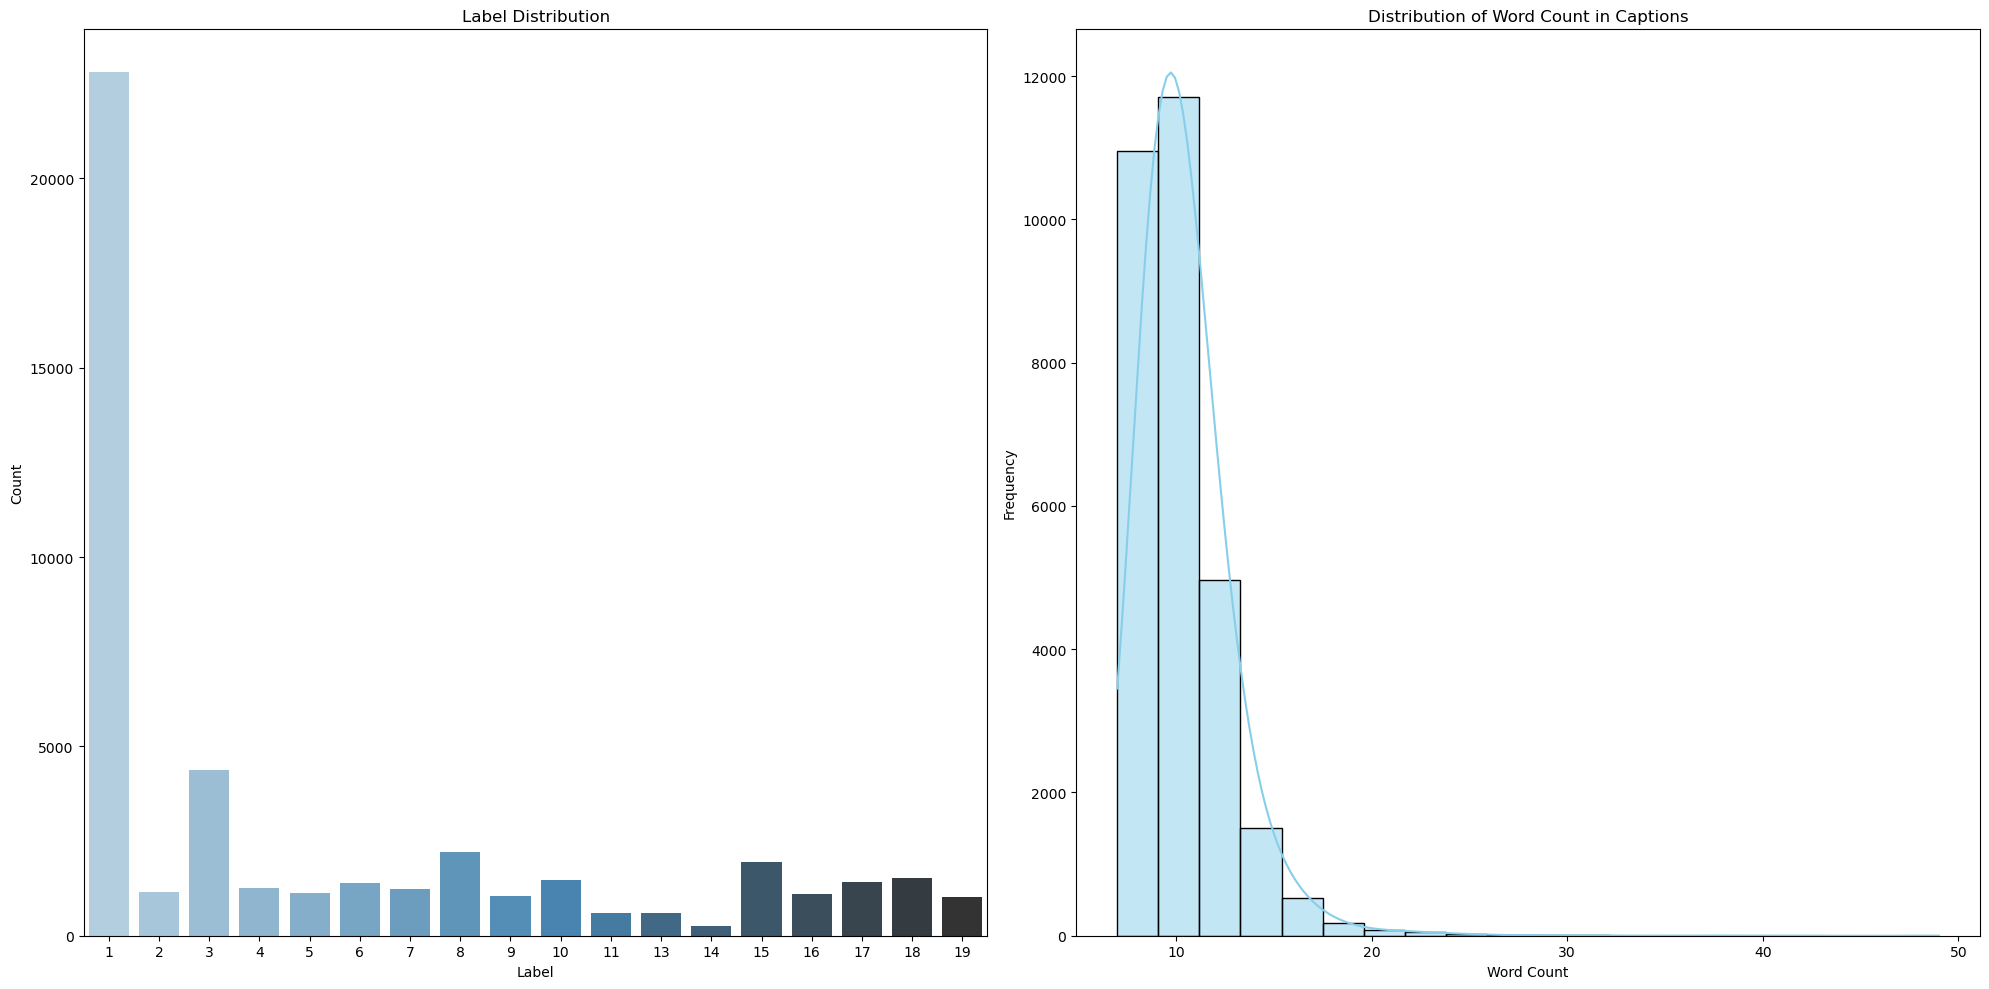

In [ ]:
# Load your training data
df = read_data("COMP5329S1A2Dataset/train.csv")

print("Missing values per column:")
print(df.isnull().sum())

# Count label frequencies
labels = df['Labels'].str.split().explode()
label_counts = labels.value_counts().sort_index()

# Count words in each caption
caption_word_counts = df['Caption'].apply(lambda x: len(x.split()))

# Plot
plt.figure(figsize=(20, 10))

# Label distribution
# Label distribution subplot
plt.subplot(1, 2, 1)
sns.barplot(
    x=label_counts.index.astype(int),
    y=label_counts.values,
    hue=label_counts.index.astype(int),
    palette="Blues_d",
    dodge=False,
    legend=False
)

plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")

# Caption word count distribution
plt.subplot(1, 2, 2)
sns.histplot(caption_word_counts, bins=20, kde=True, kde_kws={'bw_method': 0.5}, color='skyblue')
plt.title("Distribution of Word Count in Captions")
plt.xlabel("Word Count")
plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("data_exploration.png")
plt.show()


# Model Construction

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

class RESNET18_MINIBERT_2fc_Model(nn.Module):
    def __init__(self, num_classes=19, dropout_rate=0.3):
        super(RESNET18_MINIBERT_2fc_Model, self).__init__()

        # Image encoder: pretrained ResNet18 using updated API
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        resnet_out_dim = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # remove classification head

        # Text encoder: pretrained BERT-mini
        self.bert = BertModel.from_pretrained('prajjwal1/bert-mini')
        bert_out_dim = self.bert.config.hidden_size

        # Fully connected layers
        self.fc1 = nn.Linear(resnet_out_dim + bert_out_dim, 512)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, num_classes)


    def forward(self, images, input_ids, attention_mask):
        img_feat = self.resnet(images)
        text_feat = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        combined = torch.cat((img_feat, text_feat), dim=1)
        x = torch.relu(self.fc1(combined))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Define Loss function and Optimizer

In [ ]:
# Count the number of positive samples for each class
all_labels = train_data['Labels'].str.split().explode().astype(int) - 1  # Convert to 0~18
label_counts = all_labels.value_counts().sort_index()
label_freq = label_counts.values
num_samples = len(train_data)

# Calculate pos_weight (negative samples / positive samples)
pos_weights = torch.tensor((num_samples - label_freq) / (label_freq + 1e-6), dtype=torch.float32)

# Define loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))


def get_optimizer(model, optimizer_type='adam', lr_img=1e-4, lr_bert=2e-5, momentum=0.9):
    # Set parameter groups for different learning rates
    param_groups = [
        {"params": model.resnet.parameters(), "lr": lr_img},
        {"params": model.bert.parameters(), "lr": lr_bert},
        {"params": model.fc1.parameters(), "lr": lr_img},
        {"params": model.fc2.parameters(), "lr": lr_img}
    ]
    if optimizer_type.lower() == 'adam':
        return optim.Adam(param_groups)
    elif optimizer_type.lower() == 'sgd':
        return optim.SGD(param_groups, momentum=momentum)
    else:
        raise ValueError("Unsupported optimizer type: use 'adam' or 'sgd'")


# Define train and validation function

In [ ]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    model.to(device)
    total_loss = 0.0
    for images, labels, input_ids, attention_mask in dataloader:
        images, labels = images.to(device), labels.to(device)
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
def validate(model, dataloader, criterion, device, thresholds=None):
    model.eval()
    model.to(device)
    total_loss = 0.0
    all_labels, all_probs = [], []
    with torch.no_grad():
        for images, labels, input_ids, attention_mask in dataloader:
            images, labels = images.to(device), labels.to(device)
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Dynamic threshold search
    if thresholds is None:
        thresholds = np.arange(0.2, 0.71, 0.05)

    best_f1 = 0
    best_thresh = 0.5
    best_acc = 0
    for thresh in thresholds:
        preds = (all_probs > thresh).astype(float)
        f1 = f1_score(all_labels, preds, average='macro', zero_division=0)
        acc = accuracy_score(all_labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
            best_acc = acc

    return total_loss / len(dataloader), best_f1, best_acc, best_thresh

In [ ]:
def predict(model, dataloader, device, threshold=0.5):
    model.eval()
    model.to(device)
    predictions = []
    image_ids = []

    with torch.no_grad():
        for images, ids, input_ids, attention_mask in dataloader:
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(images, input_ids, attention_mask)
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).int().cpu().numpy()
            predictions.extend(preds)
            image_ids.extend(ids)

    return image_ids, predictions

def save_predictions(image_ids, predictions, filename="Predicted_labels.txt"):
    with open(filename, "w") as f:
        f.write("ImageID,Label\n")
        for img_id, pred in zip(image_ids, predictions):
            labels = " ".join(str(i + 1) for i, val in enumerate(pred) if val == 1)
            f.write(f"{img_id},{labels}\n")


# Hyper Parameter tuning

In [ ]:
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

We are using CPU.


In [ ]:
# Use all training and validation data
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

print("Training data size:", train_data.shape)
print("Validation data size:", valid_data.shape)

train_dataset = TrainImageDataset(
    data=train_data,
    img_dir="COMP5329S1A2Dataset/data",
    tokenizer=tokenizer,
    transform=train_transform
)

valid_dataset = TrainImageDataset(
    data=valid_data,
    img_dir="COMP5329S1A2Dataset/data",
    tokenizer=tokenizer,
    transform=valid_transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=0)

# Calculate pos_weight based on the full training data
full_index = pd.Index(range(1, 20))
label_counts = train_data['Labels'].str.split().explode().astype(int).value_counts().reindex(full_index, fill_value=1)
total = label_counts.sum()
pos_weight = (total - label_counts) / label_counts
pos_weight = torch.tensor(pos_weight.values, dtype=torch.float32).to(device)

print("pos_weight shape:", pos_weight.shape)

Training data size: (23996, 3)
Validation data size: (6000, 3)
pos_weight shape: torch.Size([19])


In [ ]:
import os
import time
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
num_epochs = 6

learning_rates = [2e-5, 1e-5]   # Or your own range
dropout_rates = [0.1, 0.3]
optimizers = ['adam']

results = {}
best_f1 = 0
best_params = {}

total_start = time.time()

for opt in optimizers:
    for lr in learning_rates:
        for dr in dropout_rates:
            key = f"{opt}_lr{lr:.6f}_dr{dr}"
            results[key] = {'f1': [], 'accuracy': [], 'loss': []}
            print(f"\n-----------------------------")
            print(f"Testing optimizer={opt}, lr={lr:.6f}, dropout={dr}")

            model = RESNET18_MINIBERT_2fc_Model(num_classes=19, dropout_rate=dr).to(device)
            print("Model created.")

            optimizer = optim.Adam([
                {"params": model.resnet.parameters(), "lr": lr},
                {"params": model.fc1.parameters(), "lr": lr},
                {"params": model.fc2.parameters(), "lr": lr},
                {"params": model.bert.parameters(), "lr": lr}
            ])

            combo_start = time.time()
            for epoch in range(num_epochs):
                print(f"Epoch {epoch + 1}/{num_epochs}")

                epoch_start = time.time()
                train_loss = train(model, train_loader, criterion, optimizer, device)  # 已改
                epoch_train_time = time.time() - epoch_start
                print(f"Train Loss: {train_loss:.4f} | Time: {epoch_train_time:.2f}s")

                val_start = time.time()
                valid_loss, valid_f1, valid_acc, best_thresh = validate(model, valid_loader, criterion, device)  # 已改
                print(f"Val Loss: {valid_loss:.4f}, F1: {valid_f1:.4f}, Acc: {valid_acc:.4f}, Best Thresh: {best_thresh:.2f} | Time: {time.time() - val_start:.2f}s")

                results[key]['f1'].append(valid_f1)
                results[key]['accuracy'].append(valid_acc)
                results[key]['loss'].append(valid_loss)

                if valid_f1 > best_f1:
                    best_f1 = valid_f1
                    best_params = {
                        'optimizer': opt,
                        'lr': lr,
                        'dropout_rate': dr,
                        'epoch': epoch + 1
                    }
                    torch.save(model.state_dict(), "para_model.pth")

            combo_end = time.time()
            print(f"Combination {key} finished in {combo_end - combo_start:.2f}s")

total_end = time.time()
print(f"\n Total tuning time: {total_end - total_start:.2f}s")
print(f"Best parameters found -- Optimizer: {best_params['optimizer']}, "
      f"Learning Rate: {best_params['lr']:.6f}, Dropout Rate: {best_params['dropout_rate']}, "
      f"Epoch: {best_params['epoch']}, Best F1 Score: {best_f1:.4f}")

model_size = os.path.getsize("para_model.pth") / (1024 * 1024)
print(f"Saved model size: {model_size:.2f} MB")


-----------------------------
Testing optimizer=adam, lr=0.000020, dropout=0.1
Model created.
Epoch 1/6


KeyboardInterrupt: 

In [ ]:
# 📊 Plotting
metrics = ['f1', 'loss']
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    for key, values in results.items():
        axs[i].plot(range(1, len(values[metric]) + 1), values[metric], marker='o', label=key)
    axs[i].set_title(f"{metric.upper()} over Epochs")
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel(metric.upper())
    axs[i].legend()

plt.tight_layout()
plt.savefig("hyperparam_f1_loss.png")
plt.show()

model_size = os.path.getsize("para_model.pth") / (1024 * 1024)
print(f"\n Saved model size: {model_size:.2f} MB")

print("\n Best parameters to reuse for ablation:")
print(f"best_params = {{")
print(f"    'optimizer': '{best_params['optimizer']}',")
print(f"    'lr': {best_params['lr']},")
print(f"    'dropout_rate': {best_params['dropout_rate']},")
print(f"    'epoch': {best_params['epoch']}")
print(f"}}")


# Ablation studies

In [ ]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# ResNet-only model (no caption input)
class RESNET18_ONLY_Model(nn.Module):
    def __init__(self, num_classes=19, dropout_rate=0.1):
        super(RESNET18_ONLY_Model, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # remove classification head

        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, image):
        features = self.resnet(image)
        return self.classifier(features)

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import os

# Dataset without caption
class ResNetOnlyTrainDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data_frame = data
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = self.data_frame.iloc[idx]['ImageID']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label_str = self.data_frame.iloc[idx]['Labels']
        label_ids = [int(x) for x in label_str.split()]
        label_tensor = torch.zeros(19, dtype=torch.float32)
        for l in label_ids:
            if 1 <= l <= 19:
                label_tensor[l - 1] = 1

        return image, label_tensor


In [ ]:
def train_resnet_only(model, dataloader, criterion, optimizer, device):
    model.train()
    model.to(device)
    total_loss = 0.0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


from sklearn.metrics import f1_score, accuracy_score

def validate_resnet_only(model, dataloader, criterion, device, threshold=0.5):
    model.eval()
    model.to(device)
    total_loss = 0.0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    acc = accuracy_score(all_labels, all_preds)
    return total_loss / len(dataloader), f1, acc

# Define transforms for ablation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
# Define dataset and dataloader
resnet_only_train_dataset = ResNetOnlyTrainDataset(sub_train_data, img_dir="COMP5329S1A2Dataset/data", transform=train_transform)
resnet_only_valid_dataset = ResNetOnlyTrainDataset(sub_valid_data, img_dir="COMP5329S1A2Dataset/data", transform=val_transform)

resnet_only_train_loader = DataLoader(resnet_only_train_dataset, batch_size=32, shuffle=True)
resnet_only_valid_loader = DataLoader(resnet_only_valid_dataset, batch_size=32, shuffle=False)

# Initialize model
model = RESNET18_ONLY_Model(num_classes=19, dropout_rate=best_params['dropout_rate']).to(device)
optimizer = get_optimizer(model, optimizer_type='adam', lr=best_params['lr'])
criterion = nn.BCEWithLogitsLoss()
num_epochs = 6

# Train & validate with timing and formatted output
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    start_train = time.time()
    train_loss = train_resnet_only(model, resnet_only_train_loader, criterion, optimizer, device)
    train_time = time.time() - start_train
    print(f"Train Loss: {train_loss:.4f} | Time: {train_time:.2f}s")

    start_val = time.time()
    val_loss, val_f1, val_acc = validate_resnet_only(model, resnet_only_valid_loader, criterion, device)
    val_time = time.time() - start_val
    print(f"Val Loss: {val_loss:.4f}, F1: {val_f1:.4f}, Acc: {val_acc:.4f} | Time: {val_time:.2f}s")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "resnet_only_model.pth")

Epoch 1/6
Train Loss: 0.1737 | Time: 357.61s


C:\Users\16023\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 0.1201, F1: 0.3423, Acc: 0.5078 | Time: 34.24s
Epoch 2/6
Train Loss: 0.1031 | Time: 358.33s


C:\Users\16023\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 0.1077, F1: 0.4773, Acc: 0.5467 | Time: 36.35s
Epoch 3/6
Train Loss: 0.0790 | Time: 353.82s


C:\Users\16023\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 0.1104, F1: 0.5009, Acc: 0.5561 | Time: 36.45s
Epoch 4/6
Train Loss: 0.0598 | Time: 357.08s


C:\Users\16023\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 0.1126, F1: 0.5438, Acc: 0.5583 | Time: 35.36s
Epoch 5/6
Train Loss: 0.0434 | Time: 355.09s


C:\Users\16023\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val Loss: 0.1236, F1: 0.5079, Acc: 0.5356 | Time: 35.88s
Epoch 6/6
Train Loss: 0.0305 | Time: 357.69s
Val Loss: 0.1302, F1: 0.5328, Acc: 0.5489 | Time: 36.21s


C:\Users\16023\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Sample small test set for debugging
test_subset = test_data.sample(n=20, random_state=42).reset_index(drop=True)

# Create test dataset
test_dataset = ImageTestDataset(test_subset, img_dir="COMP5329S1A2Dataset/data", tokenizer=tokenizer, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

# --- Load and run full (image+text) model ---
model_full = RESNET18_MINIBERT_2fc_Model(num_classes=19)
model_full.load_state_dict(torch.load("para_model.pth", map_location=device))
model_full.to(device)
model_full.eval()

# --- Load and run ResNet-only model ---
model_resnet = RESNET18_ONLY_Model(num_classes=19)
model_resnet.load_state_dict(torch.load("resnet_only_model.pth", map_location=device))
model_resnet.to(device)
model_resnet.eval()

# --- Predict with both models ---
def predict_labels(model, loader, device, is_resnet_only=False):
    all_preds = []
    with torch.no_grad():
        for batch in loader:
            if is_resnet_only:
                images = batch[0].to(device)
                outputs = model(images)
            else:
                images, _, input_ids, attention_mask = batch
                images = images.to(device)
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                outputs = model(images, input_ids, attention_mask)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            all_preds.append(preds.cpu())
    return torch.cat(all_preds, dim=0)

preds_full = predict_labels(model_full, test_loader, device, is_resnet_only=False)
preds_resnet = predict_labels(model_resnet, test_loader, device, is_resnet_only=True)

# --- Visualize comparison ---
labels_per_sample_full = preds_full.sum(dim=1).numpy()
labels_per_sample_resnet = preds_resnet.sum(dim=1).numpy()

x = np.arange(len(labels_per_sample_full))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, labels_per_sample_full, width, label='Full Model (image + text)')
plt.bar(x + width/2, labels_per_sample_resnet, width, label='ResNet Only')
plt.xlabel("Sample Index")
plt.ylabel("Predicted Label Count")
plt.title("Predicted Label Count per Sample (Full vs ResNet)")
plt.legend()
plt.tight_layout()
plt.savefig("compare_predicted_labels.png")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'resnet_only_model.pth'

In [ ]:
# Load the best saved model
model.load_state_dict(torch.load("para_model.pth", map_location=device))
model.to(device)

# Run prediction
image_ids, predictions = predict(model, test_loader, device)

# Save predictions in required format
save_predictions(image_ids, predictions, filename="Predicted_labels.txt")
